In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
%matplotlib inline

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
env = gym.make('CartPole-v1')

[2017-07-25 14:56:49,347] Making new env: CartPole-v1


In [3]:
class QNetwork:
    def __init__(self, learning_rate = 0.01, states = 4, action_no = 2, hidden = 20, name = 'QNet'):
        with tf.variable_scope(name):
            self.inputs = tf.placeholder(tf.float32, [None, states], name = 'inputs')
            
            self.actions = tf.placeholder(tf.int32, [None], name = 'actions')
            self.actions_onehot = tf.one_hot(self.actions, action_no)
            
            self.target_Q = tf.placeholder(tf.float32, [None], name = 'target')
            
            self.h1 = tf.contrib.layers.fully_connected(self.inputs, hidden)
            self.h2 = tf.contrib.layers.fully_connected(self.h1, hidden)
            #self.h3 = tf.contrib.layers.fully_connected(self.h2,hidden)
            
            self.out = tf.contrib.layers.fully_connected(self.h2, action_no, activation_fn= None)
            
            self.Q = tf.reduce_sum(tf.multiply(self.out, self.actions_onehot), axis = 1)
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
#buffer to store instances of the game
from collections import deque
class buffer():
    def __init__(self, max_len = 1000):
        self.buf = deque(maxlen = max_len)
    def add(self, exp):
        self.buf.append(exp)
    def sample(self, batch_size):
        index = np.random.choice(np.arange(len(self.buf)), size = batch_size, replace = False)
        return [self.buf[i] for i in index]

In [5]:
#parameters
train_eps = 1000
max_steps = 500
y = 0.99

explore_start = 1.0   #Initial exploration probability
explore_stop = 0.01   #minimum exploration prob
decay_rate = 0.0001   #decay constant for exponential decay of exploration probability
    
hidden_size = 64
lr = 0.0001

mem_size = 10000
batch_size = 20
pretrain_len = batch_size

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name = 'main', hidden=hidden_size, learning_rate= lr)

In [7]:
env.reset()
# s - current state of the game. 
# r - reward for current step. 0 or 1.
# d - 1 if game over

s, r, d, _ = env.step(env.action_space.sample())  

mem = buffer(max_len = mem_size)

for i in range(pretrain_len):
    action = env.action_space.sample()
    next_s, r, d, _ = env.step(action)
    
    if(d):
        next_s = np.zeros(s.shape)
        mem.add((s,action,r,next_s))
        
        env.reset()
        s, r, d, _ = env.step(env.action_space.sample())
    else:
        mem.add((s,action,r,next_s))
        s = next_s

In [8]:
saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_eps):
        total_r = 0
        t = 0
        while t < max_steps:
            step += 1
            
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():  # randomly choose whether to explore or exploit
                action = env.action_space.sample() 
            else:
                feed = {mainQN.inputs: s.reshape((1,*s.shape))}
                Qs = sess.run(mainQN.out, feed_dict = feed)
                action = np.argmax(Qs)
            
            next_s, r, d, _ = env.step(action)
            total_r += r
            
            if d == True:  #at episode end /game over
                next_s = np.zeros(s.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_r),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
               
                rewards_list.append((ep,total_r))

                mem.add((s,action,r,next_s))
                env.reset()
                s,r,d,_ = env.step(env.action_space.sample())
            
            else:
                mem.add((s,action, r, next_s))
                s = next_s
                t += 1
                
            batch = mem.sample(batch_size)
            states = np.array([ele[0] for ele in batch])
            actions = np.array([ele[1] for ele in batch])
            rewards = np.array([ele[2] for ele in batch])
            next_states = np.array([ele[3] for ele in batch])
            
            target_Qs = sess.run(mainQN.out, feed_dict = {mainQN.inputs: next_states})
            
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis = 1)
            target_Qs[episode_ends] = (0,0)
            
            targets = rewards + y * np.max(target_Qs, axis =1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.opt], feed_dict = {mainQN.inputs: states, mainQN.target_Q: targets, mainQN.actions: actions})
    saver.save(sess, ".ipynb_checkpoints/cartpole.ckpt")

            
            
                

Episode: 1 Total reward: 4.0 Training loss: 1.1956 Explore P: 0.9996
Episode: 2 Total reward: 12.0 Training loss: 1.2553 Explore P: 0.9984
Episode: 3 Total reward: 16.0 Training loss: 1.2790 Explore P: 0.9968
Episode: 4 Total reward: 25.0 Training loss: 1.1295 Explore P: 0.9944
Episode: 5 Total reward: 13.0 Training loss: 1.0991 Explore P: 0.9931
Episode: 6 Total reward: 24.0 Training loss: 1.0591 Explore P: 0.9907
Episode: 7 Total reward: 11.0 Training loss: 1.0577 Explore P: 0.9897
Episode: 8 Total reward: 10.0 Training loss: 1.0865 Explore P: 0.9887
Episode: 9 Total reward: 13.0 Training loss: 1.0355 Explore P: 0.9874
Episode: 10 Total reward: 33.0 Training loss: 1.1811 Explore P: 0.9842
Episode: 11 Total reward: 13.0 Training loss: 1.0504 Explore P: 0.9829
Episode: 12 Total reward: 13.0 Training loss: 1.1433 Explore P: 0.9817
Episode: 13 Total reward: 21.0 Training loss: 1.1766 Explore P: 0.9796
Episode: 14 Total reward: 25.0 Training loss: 1.1364 Explore P: 0.9772
Episode: 15 Tota

Episode: 116 Total reward: 10.0 Training loss: 59.1257 Explore P: 0.8069
Episode: 117 Total reward: 32.0 Training loss: 171.7192 Explore P: 0.8043
Episode: 118 Total reward: 38.0 Training loss: 45.1310 Explore P: 0.8013
Episode: 119 Total reward: 11.0 Training loss: 6.2490 Explore P: 0.8005
Episode: 120 Total reward: 12.0 Training loss: 228.5119 Explore P: 0.7995
Episode: 121 Total reward: 18.0 Training loss: 88.2238 Explore P: 0.7981
Episode: 122 Total reward: 10.0 Training loss: 91.8700 Explore P: 0.7973
Episode: 123 Total reward: 13.0 Training loss: 238.6305 Explore P: 0.7963
Episode: 124 Total reward: 17.0 Training loss: 73.5684 Explore P: 0.7949
Episode: 125 Total reward: 8.0 Training loss: 238.4796 Explore P: 0.7943
Episode: 126 Total reward: 14.0 Training loss: 148.3873 Explore P: 0.7932
Episode: 127 Total reward: 12.0 Training loss: 42.4746 Explore P: 0.7923
Episode: 128 Total reward: 25.0 Training loss: 39.9142 Explore P: 0.7903
Episode: 129 Total reward: 12.0 Training loss: 6

Episode: 229 Total reward: 42.0 Training loss: 19.0714 Explore P: 0.6549
Episode: 230 Total reward: 15.0 Training loss: 32.2588 Explore P: 0.6539
Episode: 231 Total reward: 15.0 Training loss: 40.2476 Explore P: 0.6530
Episode: 232 Total reward: 17.0 Training loss: 1.0289 Explore P: 0.6519
Episode: 233 Total reward: 13.0 Training loss: 24.9049 Explore P: 0.6510
Episode: 234 Total reward: 14.0 Training loss: 20.0553 Explore P: 0.6502
Episode: 235 Total reward: 20.0 Training loss: 0.9111 Explore P: 0.6489
Episode: 236 Total reward: 80.0 Training loss: 40.4468 Explore P: 0.6438
Episode: 237 Total reward: 10.0 Training loss: 1.1492 Explore P: 0.6431
Episode: 238 Total reward: 30.0 Training loss: 22.1034 Explore P: 0.6413
Episode: 239 Total reward: 19.0 Training loss: 20.8913 Explore P: 0.6401
Episode: 240 Total reward: 52.0 Training loss: 21.0274 Explore P: 0.6368
Episode: 241 Total reward: 23.0 Training loss: 34.9865 Explore P: 0.6353
Episode: 242 Total reward: 11.0 Training loss: 20.6403

Episode: 342 Total reward: 107.0 Training loss: 2.9380 Explore P: 0.3459
Episode: 343 Total reward: 100.0 Training loss: 2.1290 Explore P: 0.3425
Episode: 344 Total reward: 73.0 Training loss: 2.4477 Explore P: 0.3401
Episode: 345 Total reward: 191.0 Training loss: 157.0219 Explore P: 0.3339
Episode: 346 Total reward: 94.0 Training loss: 63.1706 Explore P: 0.3308
Episode: 347 Total reward: 144.0 Training loss: 3.4174 Explore P: 0.3262
Episode: 348 Total reward: 73.0 Training loss: 1.7543 Explore P: 0.3239
Episode: 349 Total reward: 118.0 Training loss: 2.3016 Explore P: 0.3203
Episode: 350 Total reward: 76.0 Training loss: 2.0572 Explore P: 0.3179
Episode: 351 Total reward: 157.0 Training loss: 3.1591 Explore P: 0.3131
Episode: 352 Total reward: 93.0 Training loss: 64.7998 Explore P: 0.3103
Episode: 353 Total reward: 102.0 Training loss: 2.2021 Explore P: 0.3073
Episode: 354 Total reward: 84.0 Training loss: 2.0980 Explore P: 0.3048
Episode: 355 Total reward: 108.0 Training loss: 116.7

Episode: 455 Total reward: 130.0 Training loss: 0.2897 Explore P: 0.1057
Episode: 456 Total reward: 114.0 Training loss: 0.2673 Explore P: 0.1046
Episode: 457 Total reward: 121.0 Training loss: 0.3334 Explore P: 0.1035
Episode: 458 Total reward: 84.0 Training loss: 0.6165 Explore P: 0.1027
Episode: 459 Total reward: 151.0 Training loss: 0.3165 Explore P: 0.1013
Episode: 460 Total reward: 87.0 Training loss: 0.3045 Explore P: 0.1005
Episode: 461 Total reward: 86.0 Training loss: 0.2211 Explore P: 0.0997
Episode: 462 Total reward: 98.0 Training loss: 0.3566 Explore P: 0.0989
Episode: 463 Total reward: 110.0 Training loss: 3.1387 Explore P: 0.0979
Episode: 464 Total reward: 101.0 Training loss: 0.3481 Explore P: 0.0970
Episode: 465 Total reward: 100.0 Training loss: 0.3297 Explore P: 0.0961
Episode: 466 Total reward: 80.0 Training loss: 0.6781 Explore P: 0.0955
Episode: 467 Total reward: 92.0 Training loss: 0.5648 Explore P: 0.0947
Episode: 468 Total reward: 126.0 Training loss: 0.2367 Ex

Episode: 568 Total reward: 86.0 Training loss: 0.1453 Explore P: 0.0238
Episode: 569 Total reward: 181.0 Training loss: 0.1720 Explore P: 0.0236
Episode: 570 Total reward: 95.0 Training loss: 0.1091 Explore P: 0.0235
Episode: 571 Total reward: 168.0 Training loss: 0.2724 Explore P: 0.0232
Episode: 572 Total reward: 499.0 Training loss: 0.1813 Explore P: 0.0226
Episode: 573 Total reward: 91.0 Training loss: 0.2654 Explore P: 0.0225
Episode: 574 Total reward: 93.0 Training loss: 0.1672 Explore P: 0.0224
Episode: 575 Total reward: 239.0 Training loss: 0.1258 Explore P: 0.0221
Episode: 576 Total reward: 121.0 Training loss: 0.1497 Explore P: 0.0219
Episode: 577 Total reward: 499.0 Training loss: 0.0787 Explore P: 0.0213
Episode: 578 Total reward: 418.0 Training loss: 0.1489 Explore P: 0.0209
Episode: 579 Total reward: 123.0 Training loss: 0.2537 Explore P: 0.0208
Episode: 580 Total reward: 499.0 Training loss: 0.1618 Explore P: 0.0202
Episode: 581 Total reward: 168.0 Training loss: 0.2687 

Episode: 681 Total reward: 499.0 Training loss: 0.1208 Explore P: 0.0101
Episode: 682 Total reward: 499.0 Training loss: 0.0870 Explore P: 0.0101
Episode: 683 Total reward: 499.0 Training loss: 0.3202 Explore P: 0.0101
Episode: 684 Total reward: 499.0 Training loss: 0.0789 Explore P: 0.0101
Episode: 685 Total reward: 499.0 Training loss: 0.1576 Explore P: 0.0101
Episode: 686 Total reward: 499.0 Training loss: 0.1070 Explore P: 0.0101
Episode: 687 Total reward: 499.0 Training loss: 0.1657 Explore P: 0.0101
Episode: 688 Total reward: 491.0 Training loss: 0.0878 Explore P: 0.0101
Episode: 689 Total reward: 499.0 Training loss: 0.0645 Explore P: 0.0101
Episode: 690 Total reward: 499.0 Training loss: 0.0922 Explore P: 0.0101
Episode: 691 Total reward: 499.0 Training loss: 0.1432 Explore P: 0.0101
Episode: 692 Total reward: 499.0 Training loss: 0.1415 Explore P: 0.0101
Episode: 693 Total reward: 499.0 Training loss: 0.2621 Explore P: 0.0101
Episode: 694 Total reward: 499.0 Training loss: 0.2

Episode: 794 Total reward: 499.0 Training loss: 0.0697 Explore P: 0.0100
Episode: 795 Total reward: 499.0 Training loss: 0.0699 Explore P: 0.0100
Episode: 796 Total reward: 499.0 Training loss: 0.0555 Explore P: 0.0100
Episode: 797 Total reward: 499.0 Training loss: 0.1186 Explore P: 0.0100
Episode: 798 Total reward: 488.0 Training loss: 0.0378 Explore P: 0.0100
Episode: 799 Total reward: 499.0 Training loss: 0.0621 Explore P: 0.0100
Episode: 800 Total reward: 499.0 Training loss: 0.1078 Explore P: 0.0100
Episode: 801 Total reward: 499.0 Training loss: 0.0485 Explore P: 0.0100
Episode: 802 Total reward: 499.0 Training loss: 0.0921 Explore P: 0.0100
Episode: 803 Total reward: 499.0 Training loss: 0.0894 Explore P: 0.0100
Episode: 804 Total reward: 462.0 Training loss: 0.0851 Explore P: 0.0100
Episode: 805 Total reward: 449.0 Training loss: 0.0918 Explore P: 0.0100
Episode: 806 Total reward: 499.0 Training loss: 0.0652 Explore P: 0.0100
Episode: 807 Total reward: 499.0 Training loss: 0.0

Episode: 907 Total reward: 499.0 Training loss: 0.0647 Explore P: 0.0100
Episode: 908 Total reward: 499.0 Training loss: 95.5046 Explore P: 0.0100
Episode: 909 Total reward: 499.0 Training loss: 0.1189 Explore P: 0.0100
Episode: 910 Total reward: 499.0 Training loss: 0.1630 Explore P: 0.0100
Episode: 911 Total reward: 499.0 Training loss: 0.1224 Explore P: 0.0100
Episode: 912 Total reward: 499.0 Training loss: 0.0958 Explore P: 0.0100
Episode: 913 Total reward: 499.0 Training loss: 0.0502 Explore P: 0.0100
Episode: 914 Total reward: 499.0 Training loss: 0.0488 Explore P: 0.0100
Episode: 915 Total reward: 499.0 Training loss: 0.0994 Explore P: 0.0100
Episode: 916 Total reward: 499.0 Training loss: 0.1835 Explore P: 0.0100
Episode: 917 Total reward: 499.0 Training loss: 0.1337 Explore P: 0.0100
Episode: 918 Total reward: 499.0 Training loss: 0.1362 Explore P: 0.0100
Episode: 919 Total reward: 499.0 Training loss: 0.0994 Explore P: 0.0100
Episode: 920 Total reward: 499.0 Training loss: 0.

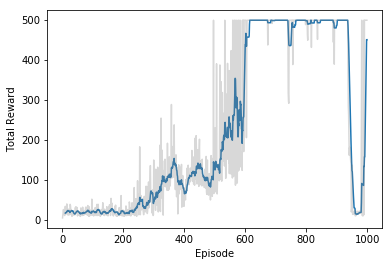

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [12]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.ipynb_checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render()
            # Get action
            feed = {mainQN.inputs: s.reshape((1, *s.shape))}
            Qs = sess.run(mainQN.out, feed_dict=feed)
            action = np.argmax(Qs)
            
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from .ipynb_checkpoints\cartpole.ckpt


[2017-07-25 15:13:22,223] Restoring parameters from .ipynb_checkpoints\cartpole.ckpt


In [13]:
env.close()